In [1]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.insert(1, '/Users/bangun/pyptychostem-master')
from STEM4D import Data4D, SSB, WDD
from libertem.common import Shape 
from scipy.ndimage import center_of_mass  
from live_wdd.live_wdd import prepare_livewdd
from live_wdd.wdd_udf import WDDUDF
import time
import numpy as np

cannot load pixstem package...
4D plot not possible


In [3]:
import matplotlib.pyplot as plt

In [4]:
from libertem.udf.sum import SumUDF

In [5]:
from libertem.api import Context

In [6]:
#!/usr/bin/env python3

from STEM4D import Data4D, SSB, WDD
import numpy as np
import multiprocessing
#import hyperspy.api as hs
#%matplotlib tk
#import hyperspy.extensions
import sys
try:
    import pixstem.api as ps
except:
    print('cannot load pixstem package...')
    print('iCOM not possible')


if len(sys.argv)==1:
    parfile = sys.argv[1]
else:
 
    #parfile ='/Users/bangun/pyptychostem/parameters_moellenstedt.txt'
    parfile ='/Users/bangun/pyptychostem/parameters.txt'
    
#params = np.genfromtxt(parfile,delimiter='\t',dtype=str)
    
par_dictionary = {}

file = open(parfile)

for line in file:
    if line.startswith('##'):
        continue
    split_line = line.rstrip().split('\t')
    print(split_line)

    if len(split_line)!=2:
        continue
    key, value = split_line
    par_dictionary[key] = value


cannot load pixstem package...
iCOM not possible
['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '1']
['plot_trotters', '1']
['plot_power_spectrum', '1']
['']
['save', '1']
['#dose', '50']


In [7]:
method = par_dictionary.get('method','wdd')   
expansion_ratio = float(par_dictionary.get('CBED/BF',-1))
dose = int(par_dictionary.get('dose',-1))   

if  expansion_ratio<1:
    expansion_ratio = None
save = int(par_dictionary.get('save',1))

if method not in ['ssb','wdd','iCOM']:
    print('method not understood')


data_4D = Data4D(parfile)
data_4D.estimate_aperture_size() 

['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '1']
['plot_trotters', '1']
['plot_power_spectrum', '1']
['']
['save', '1']
['#dose', '50']
/Users/bangun/pyptychostem/
angle step in the x direction is:  0.003801610778615568


In [8]:
data_4D.truncate_ronchigram(expansion_ratio=expansion_ratio) # crops ronchigram to area of interest


In [9]:

    
data_4D.apply_FT()

wdd = WDD(data_4D)
wdd.run()

In [10]:
# Original pyptychostem reconstruction
wdd_result = wdd.Obj_function
# Double FFT2 to correct orientation
wdd_pyptycho = np.fft.fft2(np.fft.fft2(wdd_result))

In [11]:
dim = data_4D.data_4D.shape

In [12]:
from libertem.api import Context

## Load Dataset using LiberTEM

In [13]:
path = '/Users/bangun/pyptychostem-master/graphene_simu_reshaped.npy'
 
# Create context
ctx = Context()
  
ds=ctx.load("npy", path=path, nav_shape=(dim[0], dim[1]), sig_shape=(dim[2], dim[3]))  
ds.set_num_cores(4*18)


## Prepare parameters 

In [14]:
acc = float(par_dictionary['voltage'])# in kV
scan_real = float(par_dictionary['stepsize'])*1e-1 # in nm
semiconv=float(par_dictionary['aperture'])*1e3 # In mrad
rad = data_4D.aperture_radius
order = 16
com = (data_4D.center_y,data_4D.center_x)

## Check Dark Field to get reference coordinate

In [15]:
df = ctx.create_ring_analysis(dataset=ds,
                              cx=com[1], cy=com[0],
                              ri=rad+10, ro = rad + 100)

In [16]:
df_array = ctx.run(df)['intensity']

<IPython.core.display.Javascript object>


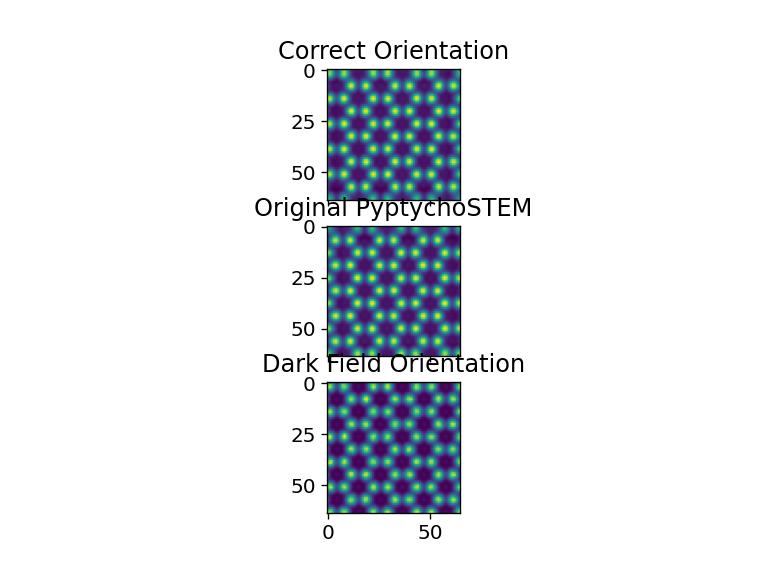

Text(0.5, 1.0, 'Dark Field Orientation')

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True)
ax1.imshow(np.angle(wdd_pyptycho))
ax2.imshow(wdd.phase)
ax3.imshow(df_array)
ax1.set_title('Correct Orientation')
ax2.set_title('Original PyptychoSTEM')
ax3.set_title('Dark Field Orientation')

## Check the fft2 fft2 operator dont change the phase value

In [18]:
np.allclose(np.sort(wdd.phase.flatten("C")),np.sort(np.angle(wdd_pyptycho).flatten("C")))

True

## Run Pre-Computed Wiener Filter

In [19]:
complex_dtype = np.complex64
scan_idx, wiener_filter_compressed,row_exp, col_exp,coeff = prepare_livewdd(ds.shape, acc, scan_real, 
                                                                            semiconv, rad, com, order,
                                                                            complex_dtype, 6.0)

timer pre computing Wiener 10.18608s


## Run Live WDD

In [20]:
%%time
complex_dtype = np.complex64
live_wddudf = ctx.run_udf(dataset=ds, roi = None, 
                       udf= WDDUDF(wiener_filter_compressed, scan_idx, coeff, row_exp, col_exp, complex_dtype))
live_wdd_recon = live_wddudf['reconstructed']


CPU times: user 542 ms, sys: 98.9 ms, total: 641 ms
Wall time: 1.67 s


In [21]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Plot the result

<IPython.core.display.Javascript object>


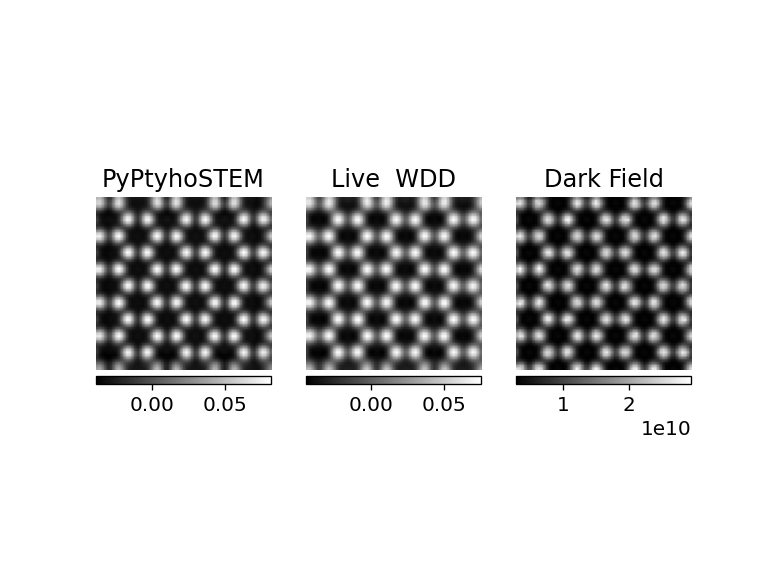

In [27]:

fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharex=True, sharey=True)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('bottom', size='5%', pad=0.05)
im1 = ax1.imshow(np.angle(wdd_pyptycho),cmap = 'gray')
im2 = ax2.imshow(np.angle(live_wdd_recon),cmap = 'gray')
im3 = ax3.imshow(df_array,cmap = 'gray')
ax1.set_axis_off()
ax1.set_title('PyPtyhoSTEM')
ax2.set_axis_off()
ax2.set_title('Live  WDD')
ax3.set_axis_off()
ax3.set_title('Dark Field')
fig.colorbar(im1, cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')
fig.colorbar(im3, cax=cax3, orientation='horizontal')
 

<IPython.core.display.Javascript object>


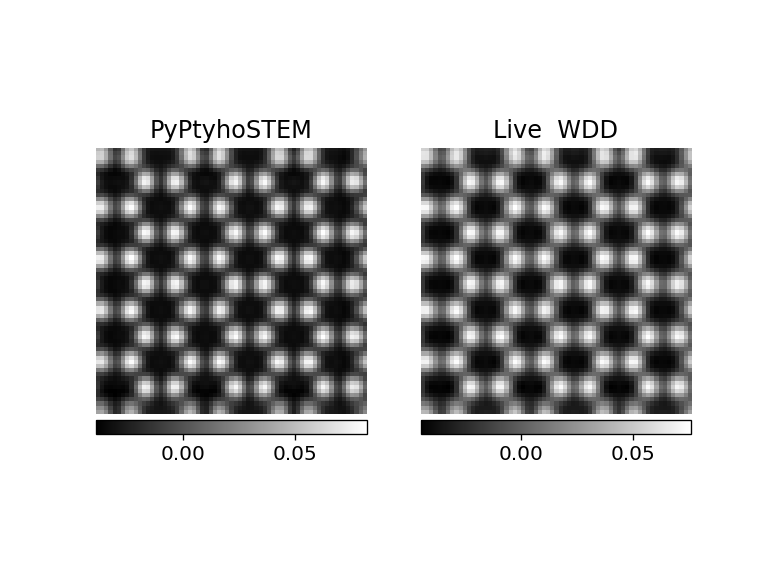

In [28]:

fig,(ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
im1 = ax1.imshow(np.angle(wdd_pyptycho),cmap = 'gray')
im2 = ax2.imshow(np.angle(live_wdd_recon),cmap = 'gray')
ax1.set_axis_off()
ax1.set_title('PyPtyhoSTEM')
ax2.set_axis_off()
ax2.set_title('Live  WDD')
fig.colorbar(im1, cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')


In [29]:
np.max(np.angle(wdd_pyptycho)), np.max(np.angle(live_wdd_recon))

(0.08171248303363922, 0.07585011)